# Data Source:
Kaggle (ongoing competition): https://www.kaggle.com/c/prudential-life-insurance-assessment

# Project goal:
Analyze features collected from individuals applying for life insurance at Prudential to predict response of the company.

**Motivation for the problem:**
Once Prudential collects features from its applicants, it takes a long time to come up with a decision. If we can come up with a model that accurately predicts the decisions they come up with, the company can use this model and swiftly determine its decision.

# Notes on dataset:
59381 rows, 127 columns: 126 features (some of which are dummy variables) and 1 outcome column. The outcome column is called **Response**. There are 8 nominal values (1,2,3,4,5,6,7,8) in the Response column.

# Immediate goal: working with a smaller subset of Prudential data 

The point is to be able to go through with a workflow on my laptop. Using the entire datasets chokes Jupyter.
- Plan to use Amazon's EC2 cloud server but for now will work with a subset sampled from the data.
- Data set (59381 rows) is randomly subsetted to a smaller df with 500 rows.

In [37]:
# Imports and magic here
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.cross_validation import train_test_split, StratifiedKFold, ShuffleSplit 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Globals here

In [2]:
# Read input dataset
input_csv = './train.csv'
df_raw = pd.read_csv(input_csv, index_col = 0)

** Randomly extract 500 rows from df_raw into df_sampled **

In [3]:
# Sample df_raw to create a smaller, easier to work with df
rows = np.random.choice(df_raw.index.values,500)
df_sampled = df_raw.ix[rows]

In [4]:
df_sampled.shape

(500, 127)

In [5]:
# Identify predictor variables and response varibales, and create corresponding DFs

def split_response_from_features(df):
    response = 'Response'
    all_predictors = [col for col in df.columns if col not in response]
    df_predictors = df[all_predictors]
    df_response = df[response]
    df_response_with_dummies = pd.get_dummies(df_response,prefix='Response')
    return df_predictors, df_response, df_response_with_dummies

In [6]:
df_predictors, df_response_with_dummies, df_response = split_response_from_features(df_sampled)

In [7]:
df_sampled.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
Id,,,,,,,,,,,,,,,,,,,,,
23800,1,D4,26,0.230769,2,3,1,0.268657,0.763636,0.361925,...,0,0,0,0,0,0,0,0,0,7
59889,1,D4,26,0.384615,2,3,1,0.179104,0.709091,0.309623,...,0,0,0,0,0,0,0,0,0,8
32451,1,D3,26,0.128205,2,3,1,0.328358,0.672727,0.138075,...,0,0,0,0,0,0,0,0,0,4
3259,1,A1,26,0.384615,2,3,1,0.104478,0.636364,0.163180,...,0,0,0,0,0,0,0,0,0,8
52814,1,D3,26,0.487179,2,1,1,0.611940,0.690909,0.330544,...,0,0,0,0,0,0,0,0,0,6


In [51]:
df_response.head()

,Response_1,Response_2,Response_3,Response_4,Response_5,Response_6,Response_7,Response_8
Id,,,,,,,,
23800,0,0,0,0,0,0,1,0
59889,0,0,0,0,0,0,0,1
32451,0,0,0,1,0,0,0,0
3259,0,0,0,0,0,0,0,1
52814,0,0,0,0,0,1,0,0


**Preliminary exploratory plots:**
1. Wt versus BMI (Intuitively one would guess there is a positive correlation).
2. Plot the distribution of Response variable to see if there are evenly represented in df_sample. If not we might need to upsample, downsample or generate rows for the underrepresented response using SMOTE.

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


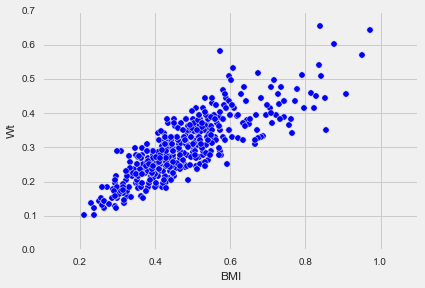

In [9]:
# Plot scatterplot of Wt vs BMI
with plt.style.context('fivethirtyeight'):
    plt.scatter(df_sampled.BMI,df_sampled.Wt,s=40)
    # add axis label
    plt.xlabel('BMI')
    plt.ylabel('Wt')
plt.show()    

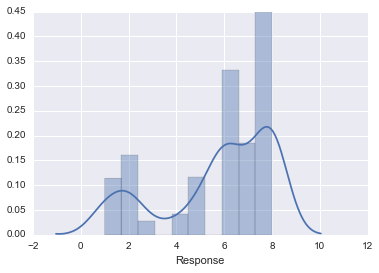

In [10]:
# Plot the distribution of Response
sns.distplot(df_sampled.Response)

In [11]:
response_count = {}
for ii in df_sampled.Response.unique():
    response_count[ii] = len(df_sampled[df_sampled.Response==ii])
    total_num = len(df_sampled[df_sampled.Response==ii])
    print "Total number of Response#{} : {}".format(ii,total_num)
print response_count       

Total number of Response#7 : 65
Total number of Response#8 : 157
Total number of Response#4 : 15
Total number of Response#6 : 116
Total number of Response#2 : 56
Total number of Response#3 : 10
Total number of Response#1 : 40
Total number of Response#5 : 41
{1: 40, 2: 56, 3: 10, 4: 15, 5: 41, 6: 116, 7: 65, 8: 157}


# Notes on the Response column
1. Response 6,8 is roughly 4-5 times higher than the rest of the responses : consider undersampling.
2. Response 3 and 4 are way less than the others: consider oversampling.

In [12]:
# Describe each feature: Number of uniques, number of nulls, type_of_feature, distribution

def get_dummy_features(df, verbose=False, dummy_threshold = 200):
    features_for_dummification = []
    num_rows = len(df)

    for each_feature in df.columns:
        num_uniques = len(df[each_feature].unique())
        num_nulls = df[each_feature].isnull().sum()
        example = df[each_feature].iloc[0]
        
        # Keep track of dummy features
        if isinstance(example, str) or (num_uniques*dummy_threshold<num_rows and isinstance(example, (int, long))): 
            features_for_dummification.append(each_feature)

        if verbose==True:
            print '{}: Uniques: {}/{}. Nulls: {}. Type: {}'.format(each_feature, num_uniques, 
                                                               num_rows, num_nulls, type_of_feature)
            
            
    return features_for_dummification

In [13]:
# check if number of dummiable columns in the original df and the sampled df are the same
print len(get_dummy_features(df_raw,verbose=False,dummy_threshold=200))
print len(get_dummy_features(df_sampled,verbose=False,dummy_threshold=200))

108
93


In [ ]:
#get_dummy_features(df_predictors)

**The answer is no: 108 for original df_raw and 94 for df_sampled. But that's ok. Just go ahead with the workflow anyway.**

In [14]:
# Turn chosen features into dummy variables
def create_dummy_features(df, features_for_dummification, verbose=True):
    df_expanded = df

    for each_feature in features_for_dummification:
        if verbose==True:
            print "Expanding variable: {}".format(each_feature)
        df_temp = pd.get_dummies(df[each_feature], prefix=each_feature)
        df_expanded = pd.concat([df_expanded, df_temp], axis = 1, join = 'inner')
        df_expanded.drop(each_feature,inplace=True, axis=1)
        
    return df_expanded

In [15]:
# # Since training data and test data have different distributions for "dummyizable" features, it makes sense to
# # build out dummy features using a combined distribution
df_oos_sneak_peek = pd.read_csv('./test.csv', index_col = 0)
df_predictors_enhanced = pd.concat([df_predictors, df_oos_sneak_peek], axis = 0, join = 'outer')
df_predictors_enhanced.shape

(20265, 126)

In [16]:
# Since Medical_Keyword is already dummied, make sure you exclude it in the dummying process!
features_for_dummification = get_dummy_features(df_predictors)
features_already_dummy = ['Medical_Keyword_{}'.format(num) for num in range(1,49)]
features_for_dummification = sorted(list(set(features_for_dummification) - set(features_already_dummy)))
print features_for_dummification

['Employment_Info_3', 'Employment_Info_5', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Medical_History_12', 'Medical_History_13', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_3', 'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_4', 'Medical_History_40', 'Medical_History_41', 'Medical_History_5', 'Medical_History_6', 'Medical_History_9', 'Product_Info_1', 'Product_Info_2', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7']


In [17]:
# Run the functions from above (df_expanded has dummy variables)
df_sample_expanded_enhanced = create_dummy_features(df_predictors_enhanced,features_for_dummification)
df_expanded = df_sample_expanded_enhanced.drop(df_oos_sneak_peek.index)
df_expanded.shape

Expanding variable: Employment_Info_3
Expanding variable: Employment_Info_5
Expanding variable: Insurance_History_1
Expanding variable: Insurance_History_2
Expanding variable: Insurance_History_3
Expanding variable: InsuredInfo_1
Expanding variable: InsuredInfo_2
Expanding variable: InsuredInfo_4
Expanding variable: InsuredInfo_5
Expanding variable: InsuredInfo_6
Expanding variable: InsuredInfo_7
Expanding variable: Medical_History_12
Expanding variable: Medical_History_13
Expanding variable: Medical_History_16
Expanding variable: Medical_History_17
Expanding variable: Medical_History_18
Expanding variable: Medical_History_19
Expanding variable: Medical_History_20
Expanding variable: Medical_History_21
Expanding variable: Medical_History_22
Expanding variable: Medical_History_23
Expanding variable: Medical_History_26
Expanding variable: Medical_History_27
Expanding variable: Medical_History_28
Expanding variable: Medical_History_29
Expanding variable: Medical_History_3
Expanding variab

(500, 205)

** Question about performing correlations: should we test this before making dummies?**

In [ ]:
# # Compute pairwise correlations of all predictors
# df_predictors = df_expanded
# df_predictor_correlations = df_predictors.corr()


In [ ]:
# # Describe pairwise correlations
# _corr_threshold = 0.5

# for pred in all_predictors:
#     df_temp = df_predictor_correlations[pred]
#     max_corr = df_temp[[idx for idx in df_temp.index if pred not in idx]].max()
#     min_corr = df_temp.min()
#     if np.isnan(max_corr)==False:
#         if abs(min_corr)>max_corr:
#             other_pred = df_temp[df_temp==min_corr].index[0]
#             mcorr = min_corr
#         else:
#             other_pred = df_temp[df_temp==max_corr].index[0]
#             mcorr = max_corr
#         if abs(mcorr)>_corr_threshold:
#             print '** ',
#         print 'mcorr({})={:.4f} with {}'.format(pred, mcorr, other_pred)

# Feature Engineering:
- Fill NAs for both the predictord and response with median estimates of the column.
- Consider localized imputing in future.
    

In [18]:
# Fill NAs with median estimates
df_predictors_selected = df_expanded
df_response_selected = df_response_with_dummies

df_predictors_selected.fillna(df_predictors_selected.median(),inplace=True)
df_response_selected.fillna(df_response_selected.median(),inplace=True)

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**Notes on Response variable:**
    
When I use all 8 dummy columns for response, I get "bad shape" error below. I will try using just one Response columns(1 through 8) 
and try OnevsRest or some method...

- Test how separable the resposnes are by plotting a 2D projection of the feature space and coloring by response.
- For each type of response, find the most correlated feature.

In [20]:
# Assign predictors to X and response to Y
X = df_predictors_selected
#y = df_response_selected
y = df_response_selected

In [21]:
print X.shape
print y.shape

(500, 205)
(500,)


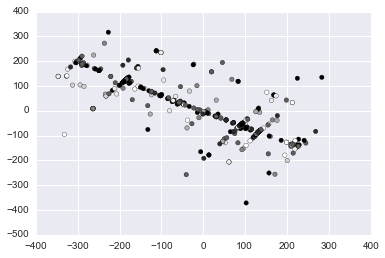

In [22]:
# Check how separable the responses are using MDS
data_to_cluster = X
mds = MDS(n_components=2,random_state=1)
mds_transformed_data = mds.fit_transform(data_to_cluster)
mds_transformed_data_df = pd.DataFrame(mds_transformed_data, columns= ['MDS1','MDS2'])
mds_transformed_data_df.head()
colors = y
plt.scatter(mds_transformed_data_df['MDS1'].values,mds_transformed_data_df['MDS2'].values,c=colors)
plt.show()

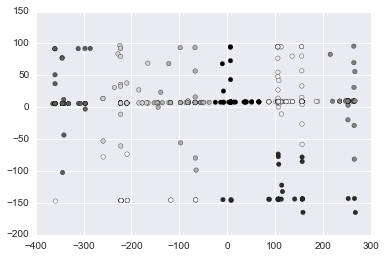

In [129]:

# Make 11 clusters using KMeans clustering
k = 8
km = KMeans(k)
cluster_info = km.fit(X)

# PCA to visulaize clusters
pca = PCA(n_components=2,copy=True)
transformed_data = pca.fit_transform(data_to_cluster)
transformed_data_df = pd.DataFrame(transformed_data, columns= ['PCA1','PCA2'])
transformed_data_df.head()
colors = cluster_info.labels_
plt.scatter(transformed_data_df['PCA1'].values,transformed_data_df['PCA2'].values,c=colors)
plt.show()


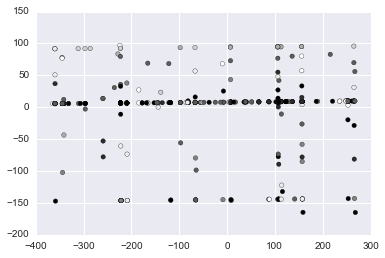

In [48]:
# Check how separable the responses using PCA
data_to_cluster = X
pca = PCA(n_components=2,copy=True)
pca_transformed_data = pca.fit_transform(data_to_cluster)
pca_transformed_data_df = pd.DataFrame(pca_transformed_data, columns= ['PCA1','PCA2'])
pca_transformed_data_df.head()
colors = y
plt.scatter(pca_transformed_data_df['PCA1'].values,pca_transformed_data_df['PCA2'].values,c=colors)
plt.show()

In [ ]:
# # Compute pairwise correlations of all predictors
# df_predictors = df_expanded
# df_predictor_correlations = df_predictors.corr()


In [ ]:
# # Describe pairwise correlations
# _corr_threshold = 0.5
all_predictors = df_predictors_selected.columns
# for pred in all_predictors:
#     df_temp = df_predictor_correlations[pred]
#     max_corr = df_temp[[idx for idx in df_temp.index if pred not in idx]].max()
#     min_corr = df_temp.min()
#     if np.isnan(max_corr)==False:
#         if abs(min_corr)>max_corr:
#             other_pred = df_temp[df_temp==min_corr].index[0]
#             mcorr = min_corr
#         else:
#             other_pred = df_temp[df_temp==max_corr].index[0]
#             mcorr = max_corr
#         if abs(mcorr)>_corr_threshold:
#             print '** ',
#         print 'mcorr({})={:.4f} with {}'.format(pred, mcorr, other_pred)

In [62]:
df_response

,Response_1,Response_2,Response_3,Response_4,Response_5,Response_6,Response_7,Response_8
Id,,,,,,,,
23800,0,0,0,0,0,0,1,0
59889,0,0,0,0,0,0,0,1
32451,0,0,0,1,0,0,0,0
3259,0,0,0,0,0,0,0,1
52814,0,0,0,0,0,1,0,0
56073,0,1,0,0,0,0,0,0
55342,0,1,0,0,0,0,0,0
73745,0,0,0,0,0,0,1,0
53571,0,0,0,0,0,1,0,0


In [61]:
for response in df_response[df_response.Response_1:
   
        score = {}
        score[response] = 
        score.append(df_response[response].corr(df_predictors_selected[predictor]))
        #print 'corr of response {} with feature {}: {}'.format(response,predictor,(df_response[response].corr(df_predictors_selected[predictor]
                                                                                                            # )))
    

In [124]:
score_result_1 = {}
for predictor in X:    
    score_result_1[predictor]= X[predictor].corr(df_response['Response_1'])
    
inverse = [(value,key) for key, value in score_result_1.items() ]
print "Max correlated feature with Result_1: {}".format(max(inverse)[1])
print min(inverse)[1]

Max correlated feature with Result_1: Medical_History_40_1


(0.0098776520351688529, 'BMI')

In [128]:
from pylab import*
for ii in df_response:
    score_result_ii = {}
    for predictor in X:
        score_result_ii[predictor] = X[predictor].corr(df_response[ii])
    inverse = [(value,key) for key, value in score_result_ii.items()]
#     pos = arange(1)
#     plt.barh(pos,max(inverse)[0],align='center')
#     yticks(pos, (max(inverse)[1]))
#     plt.show()
    print "Max positively correlated feature with Result_{}: {}, correlation: {}".format(ii,max(inverse)[1],max(inverse)[0])
    print "Min negatively correlated feature with Result_{}: {},correlation: {}".format(ii,min(inverse)[1],min(inverse)[0])

Max positively correlated feature with Result_Response_1: Medical_History_40_1, correlation: 0.17061709137
Min negatively correlated feature with Result_Response_1: Medical_History_40_3,correlation: -0.17061709137
Max positively correlated feature with Result_Response_2: Medical_Keyword_3, correlation: 0.255023238466
Min negatively correlated feature with Result_Response_2: Medical_History_39_3,correlation: -0.199165994426
Max positively correlated feature with Result_Response_3: InsuredInfo_5_3, correlation: 0.226158246847
Min negatively correlated feature with Result_Response_3: InsuredInfo_5_1,correlation: -0.226158246847
Max positively correlated feature with Result_Response_4: Medical_History_4_1, correlation: 0.187561776764
Min negatively correlated feature with Result_Response_4: Medical_History_15,correlation: -0.254842077436
Max positively correlated feature with Result_Response_5: BMI, correlation: 0.278575278099
Min negatively correlated feature with Result_Response_5: Produ

In [ ]:
for 

# Learning curve

The point is to see if we have enough data. We will do this by determining cross-validated training and test scores for different training set sizes. I'm going to give this a shot with Logistic Regression using all features.

In [23]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# estimator = LogisticRegression()
# title = "Learning curve Logistic Regression"
# #cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=100,test_size=0.2, random_state=0)
# cv=StratifiedKFold(y,n_folds=5,shuffle=True,random_state=1)
# # plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
# # plt.show()

# Model building:

**Make another version of the data where the minority response values are oversampled OR synthetically generated using SMOTE. First use the original dataset and then the altered for each model:[X,y OR X1,y1]**

1) Fit following models using all features:
    - Logistic Regression
    - Naive Bayes
    - K-Nearest Neighbor



2) Plot learning curve for any (?) model that gives a decent accuracy to see if we have enough data in hand!!



3) Fit ensemble models using all features:
    - RandomForest
    - Gradient Boosting Classifier
    - Voting Classifier (combo of models from Step#1: show that base classifiers are better than a coin toss)
    
 
**Other points to think about:**

1) K-fold cross-validation can be folded into the model: each run will give a score: we can get the median score.


2) Feature selection: Regularization (C which is 1/lambda.. C=0.1 means high penalty. Apply Lasso). Find coefficients and discuss the importance. Look for intuitive explanations. 
2.1) For Logistic Regression and Naive Bayes, we will get probabilities so besides just looking at the median CV score,will it be useful to look at the confusion matrix, find TPR, FPR, plot a ROC curve and determine AUC? Is that of interest to Prudential??


3) To simplify the model, if scores aren't great, we can even remove features showing multicollinearity. (Should we be looking at covariance?). Besides plotting a correlation matrix, will PCA help in finding out which features are colinear (since they will be on the same axis)?




2-fold cross-validation score: 0.337973630312
3-fold cross-validation score: 0.325153374233
4-fold cross-validation score: 0.33335483871
5-fold cross-validation score: 0.353535353535
6-fold cross-validation score: 0.356732348112
7-fold cross-validation score: 0.357142857143
8-fold cross-validation score: 0.364357864358
9-fold cross-validation score: 0.351851851852
10-fold cross-validation score: 0.365384615385

Best CV score: 0.365384615385


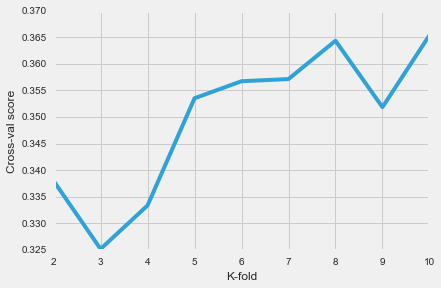

In [24]:
# Fit LOGISTIC REGRESSION model and compute the max cross_validation score over various K-folds.
model_lr = LogisticRegression(penalty = 'l1',C=0.05) # Instantiate Logistic Regression model
scores =[]
jj = 0
for ii in range(2,11):
    scores.append(np.median(cross_val_score(model_lr, X, y, cv=StratifiedKFold(y, ii, shuffle=False))))
    print "{}-fold cross-validation score: {}".format(ii,scores[jj])
    jj += 1
print '\n'"Best CV score: {}".format(max(scores))
with plt.style.context('fivethirtyeight'):
    plt.plot(range(2,11),scores)
    plt.xlabel('K-fold')
    plt.ylabel('Cross-val score')
plt.show()

In [25]:
# find the CV score for 5-fold cross-validation
cv_score_5fold = cross_val_score(model_lr,X,y,cv=5).mean()
cv_score_5fold

0.34804197312935176

In [26]:
# To obtain coefficients of features, we need to do a test train split, fit, predict, score and get coefs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
lr_fitted = model_lr.fit(X_train,y_train)
lr_fitted.score(X_test,y_test)
(lr_fitted.coef_).max()

0.024815367877830931

In [32]:
# Run KNN classifer
myknn = KNeighborsClassifier(5).fit(X_train,y_train)

# Output KNN score by running the model trained on training data on the test data
myknn.score(X_test, y_test)

0.215

In [33]:
# Run 5-fold cross-validation
model = KNeighborsClassifier(5)
data = X
label = y
cross_val_score(model, data, label, cv=StratifiedKFold(label, 5, shuffle=False))

array([ 0.18446602,  0.26      ,  0.28282828,  0.27272727,  0.22222222])

In [39]:
# Fit a Naive Bayes Model
nb = MultinomialNB()
nb.fit(X_train, y_train)
preds = nb.predict(X_test)
print metrics.accuracy_score(y_test, preds)
print metrics.confusion_matrix(y_test, preds)

0.195
[[10  0  3  2  1  1  3  0]
 [ 8  0  0  2  3  2  4  1]
 [ 0  0  2  0  0  0  1  0]
 [ 0  0  4  1  0  0  1  0]
 [ 9  1  0  0  3  0  4  2]
 [12  1  2  2  9  9 14  2]
 [10  1  0  0  1  3  6  2]
 [18  3  0  0  7  4 18  8]]


**Conclusions:**

Using all features of df_sampled, all three models are performing poorly.
- LR_accuracy: 35%
- KNN_accruacy: 21%
- Naive Bayes accuracy: 19%


**Next steps:**

- No point doing a Voting Classifier with above methods since individually all of them are bad.

- Fit gradient boosting classifier and do a grid search

- Synthetically upsample (SMOTE) response # 3,4 and downsample response 6,8 and see if performance of gradient boosting improves

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

X = df_predictors_selected
y = df_response_selected

CV_FOLDS = 2

# Set up grid search
pgrid = {'learning_rate': [0.05, 0.1, 0.5], #'n_estimators': [1, 10, 100, 1000], 
         'subsample': [0.6, 0.75, 0.9],
         'max_depth': [3,7,15]
        }

clf_grdbst = GradientBoostingClassifier(verbose=True)

grid = GridSearchCV(clf_grdbst, param_grid=pgrid, cv = CV_FOLDS)
grid.fit(X, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         276.7057           4.5571            1.98s
         2         261.3741           6.9049            2.31s
         3         243.7156           2.5919            2.25s
         4         240.5176           3.1877            2.32s
         5         225.6669           2.4165            2.29s
         6         217.9515           2.0900            2.30s
         7         208.3597           1.9492            2.33s
         8         200.8933           2.2866            2.39s
         9         200.6309           1.8663            2.37s
        10         190.3261           0.8579            2.39s
        20         136.0648           0.6535            1.84s
        30         116.3194          -0.2729            1.55s
        40          92.3989          -0.2125            1.35s
        50          77.0343          -0.2481            1.10s
        60          63.2576          -0.1690            0.90s
       

GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.75, 0.9], 'learning_rate': [0.05, 0.1, 0.5], 'max_depth': [3, 7, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [41]:
grid.best_estimator_.score(X,y)

0.94999999999999996

In [42]:
grid.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.9}

In [43]:
grid.best_score_

0.46600000000000003

In [44]:
grid.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.9,
              verbose=True, warm_start=False)

**Gradient boosting classifier accuracy = 46.6%**